# 6. Calibration of double ended measurement with OLS

A double ended calibration is performed with ordinary least squares. Over all timesteps simultaneous. $\gamma$ and $\alpha$ remain constant, while $C$ varies over time. The weights are considered equal here and no variance is calculated.

In [17]:
import os

from dtscalibration import read_xml_dir
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
try:
    wd = os.path.dirname(os.path.realpath(__file__))
except:
    wd = os.getcwd()

filepath = os.path.join(wd, '..', '..', 'tests', 'data', 'double_ended2')
timezone_netcdf = 'UTC',
timezone_ultima_xml = 'Europe/Amsterdam'
file_ext = '*.xml'

ds = read_xml_dir(filepath,
                  timezone_netcdf=timezone_netcdf,
                  timezone_ultima_xml=timezone_ultima_xml,
                  file_ext=file_ext)

ds100 = ds.sel(x=slice(0, 100))  # only calibrate parts of the fiber
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
Dask: Setting up handle for delayed readout. 1 out of 6
Dask: Setting up handle for delayed readout. 6 out of 6
Directly reading time and extra info from xml files. 1 out of 6
Directly reading time and extra info from xml files. 6 out of 6


In [19]:
print(ds100.calibration_double_ended.__doc__)



        Parameters
        ----------
        sections : dict, optional
        st_label : str
            Label of the forward stokes measurement
        ast_label : str
            Label of the anti-Stoke measurement
        rst_label : str
            Label of the reversed Stoke measurement
        rast_label : str
            Label of the reversed anti-Stoke measurement
        st_var : float, optional
            The variance of the measurement noise of the Stokes signals in the forward
            direction Required if method is wls.
        ast_var : float, optional
            The variance of the measurement noise of the anti-Stokes signals in the forward
            direction. Required if method is wls.
        rst_var : float, optional
            The variance of the measurement noise of the Stokes signals in the backward
            direction. Required if method is wls.
        rast_var : float, optional
            The variance of the measurement noise of the anti-Stokes 

In [20]:
st_label = 'ST'
ast_label = 'AST'
rst_label = 'REV-ST'
rast_label = 'REV-AST'
ds100.calibration_double_ended(sections=sections,
                               st_label=st_label,
                               ast_label=ast_label,
                               rst_label=rst_label,
                               rast_label=rast_label,
                               method='ols')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has     8430 rows  and      795 cols
damp = 0.00000000000000e+00   calc_var =        1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =     1590
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  4.82000e+02   5.046e+00  5.046e+00    1.0e+00  7.5e+00
     1  4.82000e+02   2.259e+00  2.259e+00    1.6e-01  6.3e-01   4.2e+01  1.0e+00
     2  4.81999e+02   1.401e+00  1.401e+00    9.8e-02  3.3e-01   5.6e+01  2.2e+00
     3  4.81999e+02   1.835e-01  1.835e-01    1.3e-02  5.5e-02   6.1e+01  4.3e+00
     4  4.81999e+02   1.721e-01  1.721e-01    1.2e-02  1.3e-01   6.1e+01  7.8e+00
     5  4.81999e+02   1.131e-01  1.131e-01    7.9e-03  2.3e-02   6.6e+01  1.7e+01
     6  4.81999e+02   9.214e-02  9.214e-02    6.4e-03  3.1e-04   6.6e+01  3.1e+01
     7  4.81999e+02   9.212e-02  9.212e-02    6.4e-03  7.0e-04   6.6e+01  7.4e+01
     8  4.82001e+02   9.007e

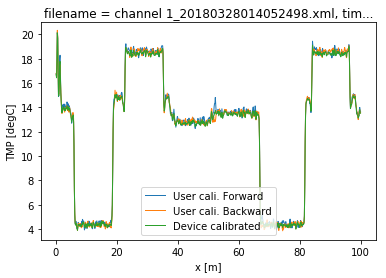

In [21]:
ds1 = ds100.isel(time=0)  # take only the first timestep

ds1.TMPF.plot(linewidth=1, label='User cali. Forward')  # plot the temperature calibrated by us
ds1.TMPB.plot(linewidth=1, label='User cali. Backward')  # plot the temperature calibrated by us
ds1.TMP.plot(linewidth=1, label='Device calibrated')  # plot the temperature calibrated by the device
plt.legend()

Lets compare our calibrated values with the device calibration. Lets average the temperature of the forward channel and the backward channel first.

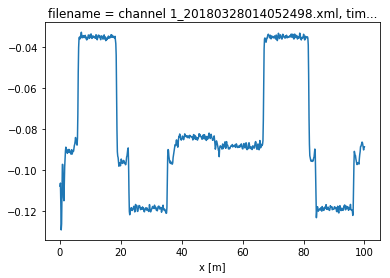

In [22]:
ds1['TMPAVG'] = (ds1.TMPF + ds1.TMPB) / 2
ds1_diff = ds1.TMP - ds1.TMPAVG
ds1_diff.plot()

The device calibration sections and calibration sections defined by us differ. The device only allows for 2 sections, one per thermometer. And most likely the $\gamma$ is fixed in the device calibration.